In [1]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import jax
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *
from sklearn.metrics import mean_absolute_error as mse
from sklearn.metrics import r2_score
from pennylane.optimize import AdamOptimizer,QNSPSAOptimizer
from scipy.optimize import minimize
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")



# Old autoencoder

In [2]:
# def autoencodert(n_qubit,repetition=2):
#   device = 'default.qubit'
#   dvc=qml.device(device, wires=n_qubit, shots=None)
#   def dense(a,b,parameters):
#       qml.RY(parameters[0],wires=a)
#       qml.RY(parameters[1],wires=b)
#       qml.CNOT(wires=[a,b])
#       qml.RY(parameters[2],wires=a)
#       qml.RY(parameters[3],wires=b)
#       qml.CNOT(wires=[b,a])

#   def pool(a,b,parameters):
#       qml.CRZ(parameters[0],wires=[a,b])
#       qml.X(a)  
#       qml.CRX(parameters[1],wires=[a,b])

#   @qml.qnode(dvc,interface='jax', diff_method=None)
#   def cirq(param):
#     start=0
#     for i in range(repetition):
#       if start % 2!=0:
#         raise Exception('The number of qubits should be a power of 2 greater than 2 to the power of repetition')

#       for a in range(start,( n_qubit-start)//2+start):
#           param_corrente=sum([6*n_qubit//2**(i+1) for i in range(i)])+a*6
#           dense(a,a+(n_qubit-start)//2,param[param_corrente:param_corrente+4])
#           pool(a,a+(n_qubit-start)//2,param[param_corrente+4:param_corrente+6])
#       start+=n_qubit//(2**(i+1))
#       qml.Barrier(dvc.wires)

#     return qml
#   return cirq,n_qubit-n_qubit//(2**(repetition))

# repetition=4
# num_params=sum([6*n_qubit//2**(i+1) for i in range(repetition)])
# cirq,trash=autoencodert(4)
# fig, ax = qml.draw_mpl(cirq)([1]*num_params)
# plt.show()



# Train autoencoder


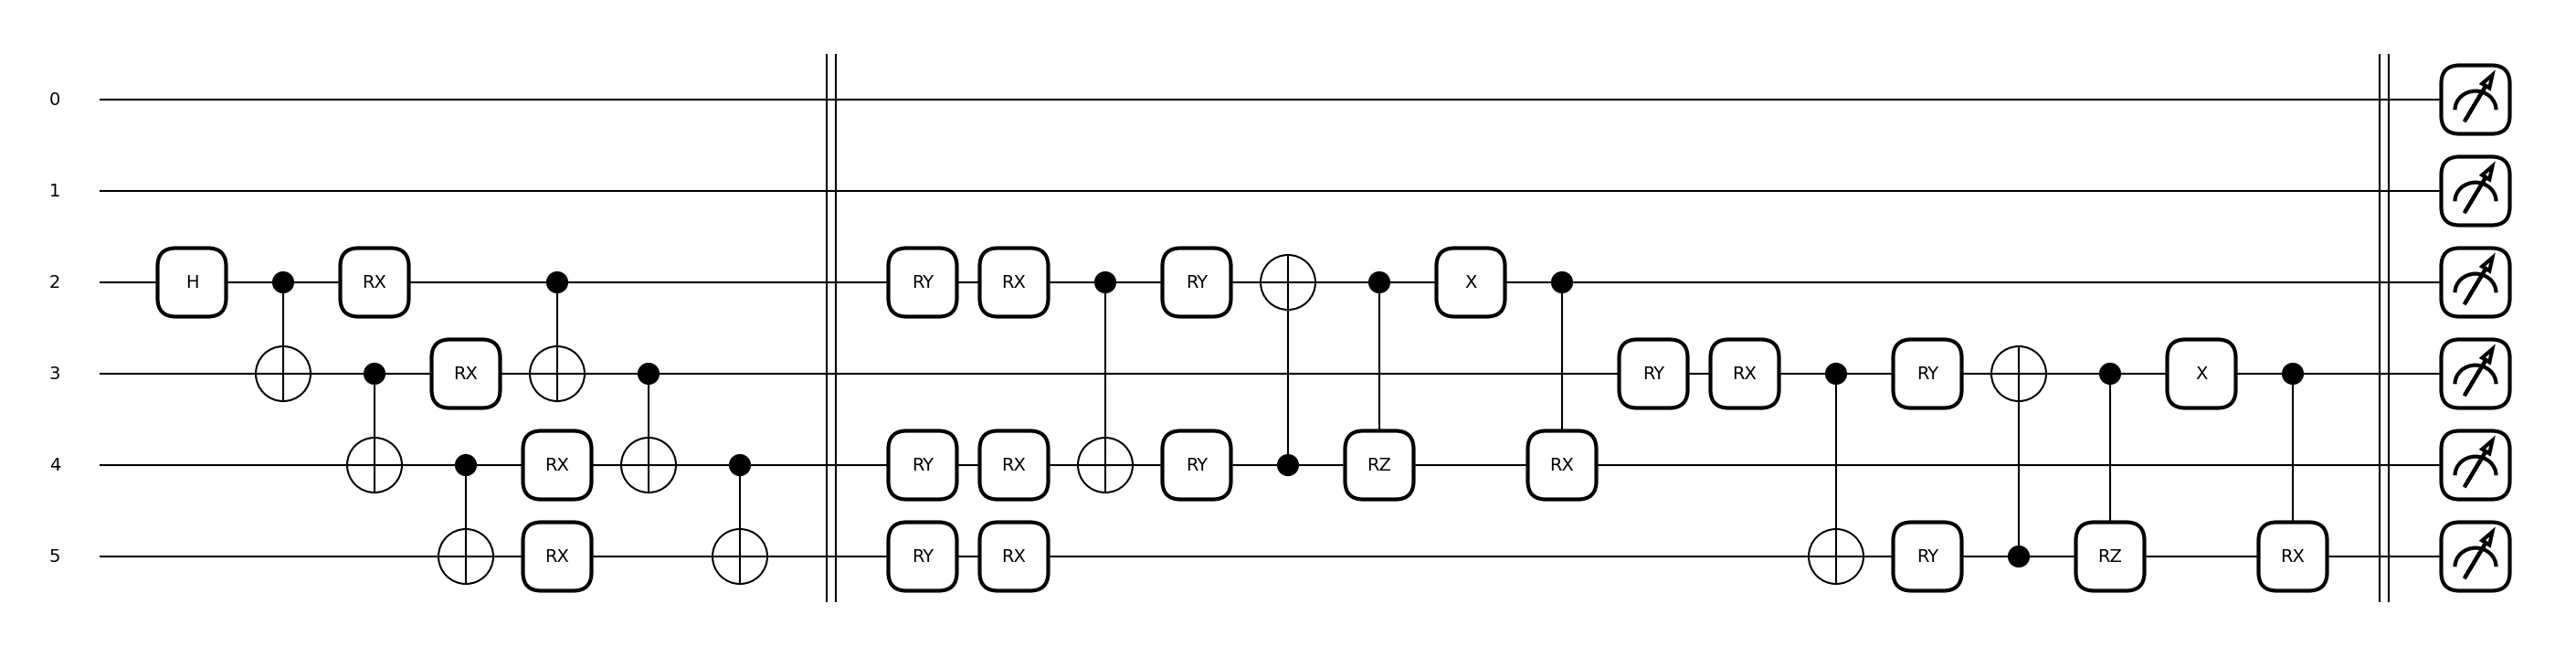

In [3]:
n_qubit_autoencoder=4
repetition=1
n_qubit_swap=n_qubit_autoencoder-n_qubit_autoencoder//(2**(repetition))
n_qubit=n_qubit_autoencoder+n_qubit_swap
num_params=sum([6*n_qubit_autoencoder//2**(i+1) for i in range(repetition)])
epochs= 50

device = 'default.qubit'
dvc=qml.device(device, wires=n_qubit, shots=None)
@qml.qnode(dvc,interface='jax', diff_method=None)
def trainer(param,p):
    create_isotropic_state(p, n_qubit_autoencoder, n_qubit_swap)
    qml.Barrier(dvc.wires)
    autoencoder(n_qubit_swap,param,repetition,n_qubit_autoencoder)
    qml.Barrier(dvc.wires)
    return qml.probs(dvc.wires)
fig, ax = qml.draw_mpl(trainer)([1]*num_params,.5)


### Trying to use the datasets from pennylanes

In [4]:
# qml.data.list_attributes('qspin')
# qml.data.list_datasets()['qspin']['Ising']
# df =qml.data.load('qspin',sysname='Ising')[0]
# print(type(df))
# df.attr_info
# type(df.hamiltonians[0])


# device = 'default.qubit'
# dvc=qml.device(device, wires=len(df.hamiltonians[0].wires), shots=None)

# @qml.qnode(dvc,interface='jax', diff_method=None)
# def useit():
#     return qml.expval(df.hamiltonians[0])
# fig, ax = qml.draw_mpl(useit)()


## simple dataset

In [5]:
def penny_train():
    loss = []   
    n_qubit_autoencoder=8
    repetition=1
    n_qubit_swap=n_qubit_autoencoder-n_qubit_autoencoder//(2**(repetition))
    n_qubit=n_qubit_autoencoder+n_qubit_swap
    num_params=sum([6*n_qubit_autoencoder//2**(i+1) for i in range(repetition)])
    epochs= 10
    n= 200
    P=np.random.rand(n)
    np.random.shuffle(P)
    y=[0]*n
    import random 
    random.seed(42)
    weights=[random.uniform(0, 1) for _ in range(num_params)]
    weights=np.array(weights,requires_grad=True)
    wq=[weights]

    dvc=qml.device(device, wires=n_qubit, shots=None)

    @qml.qnode(dvc,interface='jax',diff_method='adjoint')
    def trainer(param,p):
        create_isotropic_state(p, n_qubit_autoencoder, n_qubit_swap)()
        qml.Barrier(dvc.wires)
        autoencoder(n_qubit_swap,param,repetition,n_qubit_autoencoder)
        qml.Barrier(dvc.wires)
        destructive_swap(n_qubit_swap)
        return qml.probs(list(range(n_qubit_swap*2)))
    
    def loss_function(w): 
        pred =np.array([interpret_results(trainer(w,x)) for x in P])
    
        # clear_output(wait=True)
        print(f'Loss for current iteration: {mse(pred,y)}')
        return mse(pred,y)
    opt=AdamOptimizer()
    for _ in range(epochs):
        weights=opt.step(loss_function,weights)

    plt.plot(loss)



## full swap 

In [6]:
jax.config.update("jax_enable_x64", True)


In [31]:
def penny_train():
    loss = []   
    layerparam=6

    opt=AdamOptimizer(stepsize=.005)
    n_qubit_autoencoder=2
    repetition=1
    n_qubit_swap=n_qubit_autoencoder-n_qubit_autoencoder//(2**(repetition))+1
    n_qubit=n_qubit_autoencoder+n_qubit_swap 
    num_params=sum([layerparam*n_qubit_autoencoder//2**(i+1) for i in range(repetition)])
    epochs= 500
    n= 6
    P=np.random.rand(n)
    np.random.shuffle(P)
    y=np.array([0]*n,requires_grad=True)
    import random 
    random.seed(42)
    weights = np.array([random.uniform(0, np.pi) for _ in range(num_params)], requires_grad=True)
    wq=[weights]
    dvc=qml.device('default.qubit', wires=n_qubit, shots=None)

    @qml.qnode(dvc,diff_method='adjoint')
    def trainer(param,p):
        
        
        create_isotropic_state(p, n_qubit_autoencoder, n_qubit_swap)
        autoencoder(n_qubit_swap,param,repetition,n_qubit_autoencoder)
        original_swap(n_qubit_swap)
        
        #original_swap(n_qubit_swap)
        return qml.probs([0])
    
    fig, ax = qml.draw_mpl(trainer)(wq[-1],.56)
    plt.show(   )

    def loss_function(w): 

        pred =np.array([trainer(w,x)[1] for x in P], requires_grad=True)
        current_loss = pred.mean()
        

        return current_loss

    for epoch in range(epochs):
        weights, loss_value = opt.step_and_cost(loss_function, wq[-1])
        clear_output(wait=True)

        print(f'Epoch {epoch}: Loss = {loss_value}')

        loss.append(loss_value)
        wq.append(weights)
    return loss


In [32]:
loss=penny_train()



Epoch 499: Loss = 0.007976549679664576


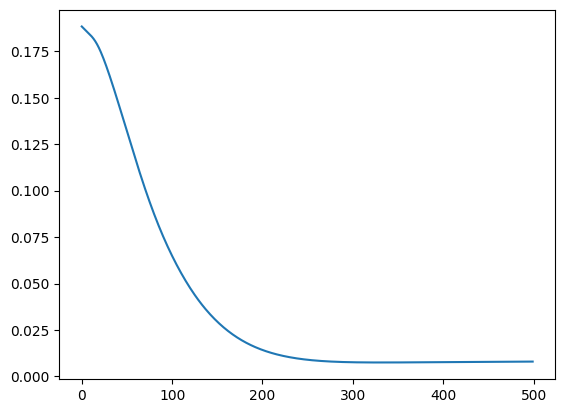

In [34]:
plt.plot(list(range(500)),loss)


In [17]:
loss_strana 

NameError: name 'loss_strana' is not defined

In [ ]:
n_qubit_swap

2

In [ ]:


def original_swap(n_qubit_swap):
  qml.Hadamard(wires=0)
  for wires in range(1,n_qubit_swap):
    qml.CSWAP(wires=[0,wires,wires+n_qubit_swap-1])
  qml.Hadamard(wires=0)
  return qml


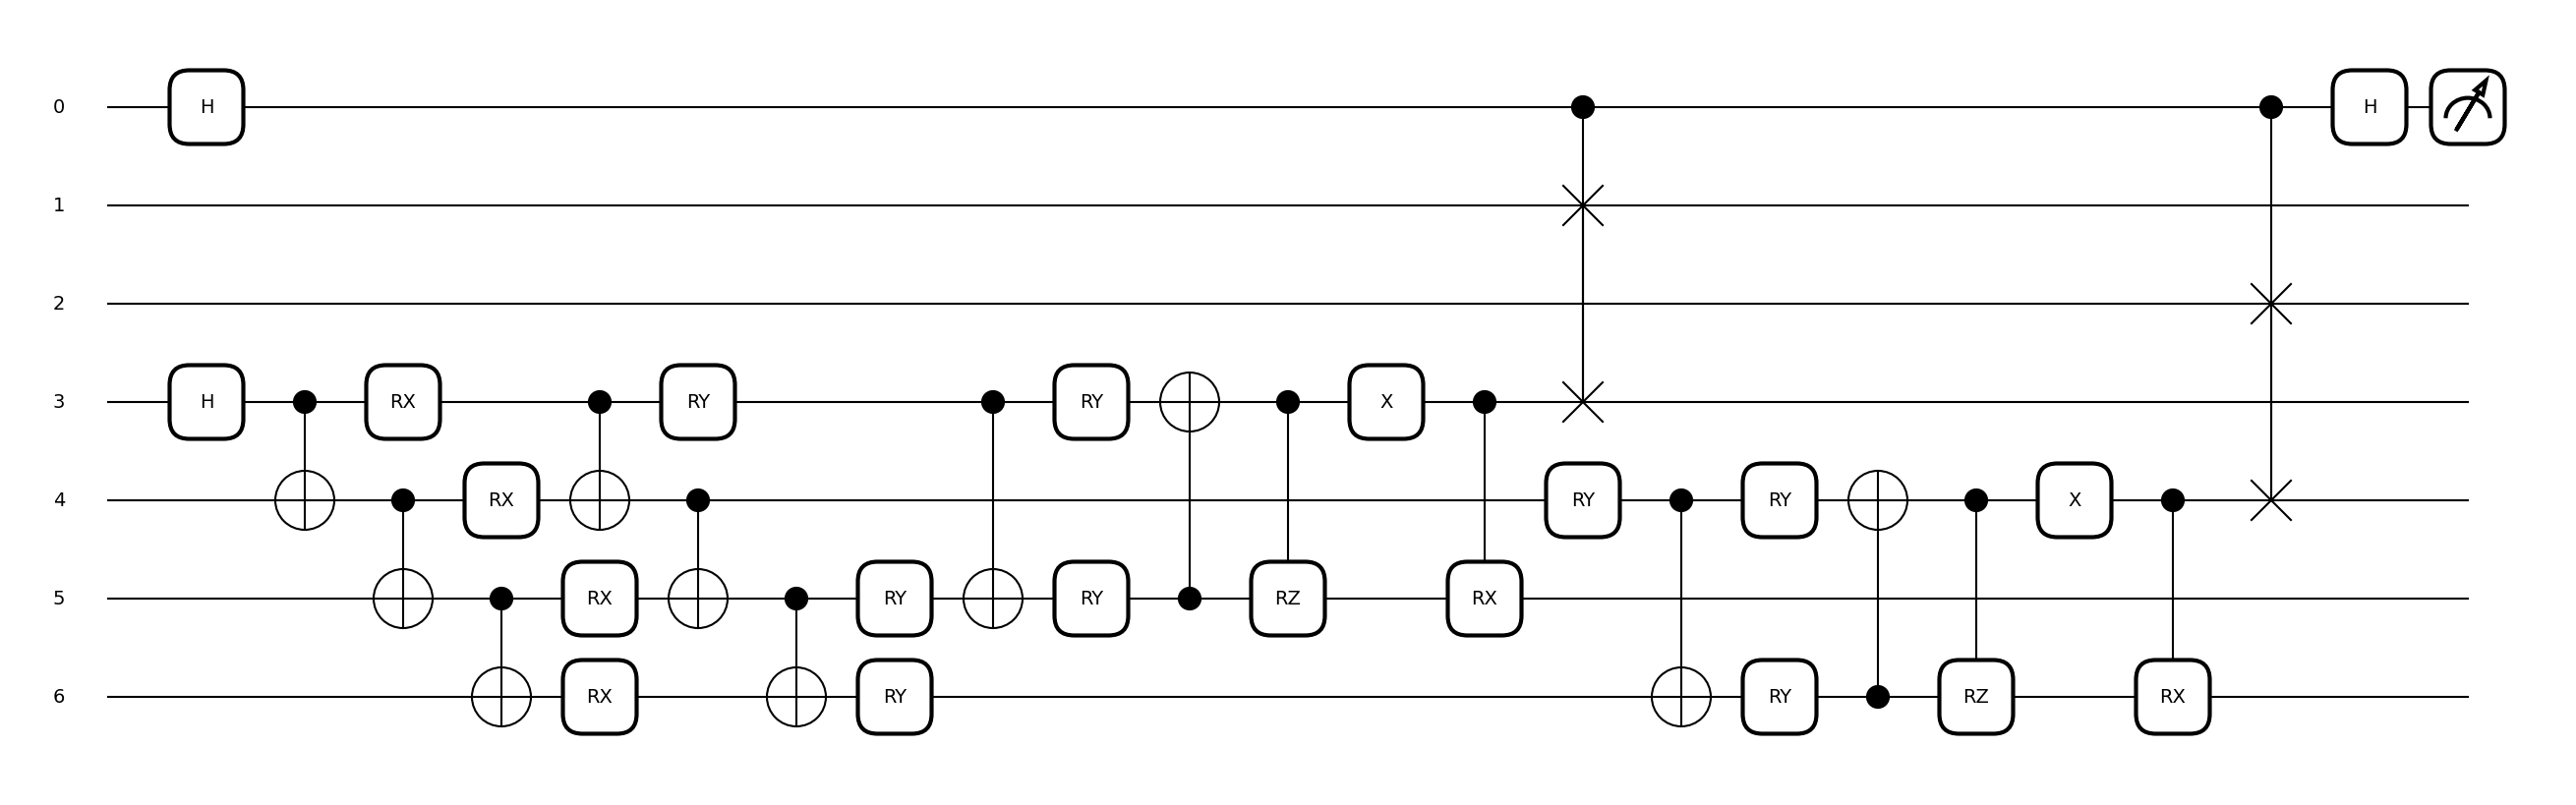

In [ ]:
n_qubit_autoencoder=4
repetition=1
n_qubit_swap=n_qubit_autoencoder-n_qubit_autoencoder//(2**(repetition))+1
n_qubit=n_qubit_autoencoder+n_qubit_swap
num_params=sum([4*n_qubit_autoencoder//2**(i+1) for i in range(repetition)])
import random 
random.seed(42)
weights = np.array([random.uniform(0, np.pi) for _ in range(num_params)], requires_grad=True)
wq=[weights]
dvc=qml.device('default.qubit', wires=n_qubit, shots=None)

@qml.qnode(dvc,diff_method='adjoint')
def trainer(param,p):
    
    
    create_isotropic_state(p, n_qubit_autoencoder, n_qubit_swap)
    autoencoder(n_qubit_swap,param,repetition,n_qubit_autoencoder)
    original_swap(n_qubit_swap)
    
    #original_swap(n_qubit_swap)
    return qml.probs([0])

fig, ax = qml.draw_mpl(trainer)(wq[-1],.56)
plt.show(   )
